# <span style='color:blue'>   TP4 : Modèles probabilistes discriminants pour le Machine Learning</span>

In [1]:
import torch
from torch import optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## <span style='color:green'>   Ex1. La fonction softmax </span>

In [2]:
def softmax(x):
    
    return torch.exp(x - torch.max(x)) / torch.sum(torch.exp(x - torch.max(x)))

In [38]:
# Testing the Softmax function
x = torch.tensor([5., 1., 2., -1.])
softmax(x)

tensor([0.9341, 0.0171, 0.0465, 0.0023])

In [39]:
# Testing the Softmax function
x = torch.tensor([200005., 200003., 200000., 200000.])
softmax(x)

tensor([0.8705, 0.1178, 0.0059, 0.0059])

## <span style='color:green'>   Ex2. Classification de chiffre avec la régression logistique</span>

In [40]:
dataset = torchvision.datasets.MNIST("./", download = True)
train_set_y, train_set_x = dataset.data[:50000], dataset.targets[:50000]
test_set_y, test_set_x = dataset.data[50000:], dataset.targets[50000:]

train_set_y = (train_set_y.view(50000, -1) + 0.0)
mean_train, std_train = torch.mean(train_set_y), torch.std(train_set_y)
train_set_y = (train_set_y - mean_train)/std_train

train_set = []
for i in range(50000):
    train_set.append([train_set_x[i], train_set_y[i]])

test_set_y = (test_set_y.view(10000, -1) + 0.0)
mean_test, std_test = torch.mean(test_set_y), torch.std(test_set_y)
test_set_y = (test_set_y - mean_test)/std_test

test_set = []
for i in range(10000):
    test_set.append([test_set_x[i], test_set_y[i]])

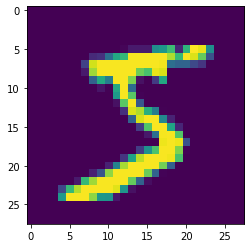

tensor(5)


In [41]:
exemple = 0
plt.imshow(train_set[exemple][1].view(28, 28))
plt.show()
print(train_set[exemple][0])

In [42]:
# Import parameters of the Logistic Regression
W_lr = torch.load("TP4_functions/W_lr.pt").requires_grad_(True)
b_lr = torch.load("TP4_functions/b_lr.pt").requires_grad_(True)

In [50]:
batch_index = list(np.random.randint(0,len(train_set),256))
batch = [train_set[i] for i in batch_index]

In [43]:
# Définition de la fonction de Loss
def L(softmax, train_set, W, b):
    
    N = len(train_set)
    
    s=0
    pred = []
    for elt in train_set:
        x = elt[0]
        y = elt[1]
        z = softmax((W @ y + b))
        s+=torch.log(z[x])
        pred.append((torch.argmax(z) == x).numpy())
    score = np.mean(pred)
    s /= (-N)
    return s, score

In [44]:
%%time
L(softmax, train_set[:100], W_lr, b_lr)

CPU times: user 17.7 ms, sys: 5.67 ms, total: 23.3 ms
Wall time: 23.5 ms


(tensor(2.4652, grad_fn=<DivBackward0>), 0.05)

I̲t̲e̲r̲a̲t̲i̲o̲n̲: 0
Loss: tensor(2.4416)
Score: 7.81 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 100
Loss: tensor(1.7758)
Score: 47.27 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 200
Loss: tensor(1.3619)
Score: 70.31 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 300
Loss: tensor(1.1752)
Score: 76.17 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 400
Loss: tensor(0.9763)
Score: 77.73 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 500
Loss: tensor(0.8737)
Score: 79.69 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 600
Loss: tensor(0.7781)
Score: 82.03 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 700
Loss: tensor(0.7300)
Score: 81.64 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 800
Loss: tensor(0.6361)
Score: 84.38 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 900
Loss: tensor(0.5450)
Score: 89.84 %
---------------------


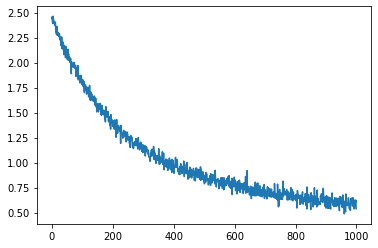

---------------------
Final score: 90.62 %
---------------------
CPU times: user 46.3 s, sys: 548 ms, total: 46.8 s
Wall time: 47.2 s


In [45]:
%%time
alpha = 5 * 10**(-5)

K = 1000
list_L = torch.zeros(K)
optimizer = optim.Adam([W_lr, b_lr], lr=alpha)

#batch_index = list(np.random.randint(0,len(train_set),256))
#batch = [train_set[i] for i in batch_index]

for k in range(K):
    
    batch_index = list(np.random.randint(0,len(train_set),256))
    batch = [train_set[i] for i in batch_index]
    
    optimizer.zero_grad()
    loss, score = L(softmax, batch, W_lr, b_lr)
    loss.backward()
    optimizer.step()
    loss

    list_L[k] = loss.item()

    if k % 100 == 0:
        
        print('{:s}'.format('\u0332'.join('Iteration:')), k)
        print("Loss:", list_L[k])
        print("Score: {} %".format(np.round(score*100,2)))
        print('---------------------')

plt.plot(list_L)
plt.show()

print('---------------------')
print("Final score: {} %".format(np.round(score*100,2)))
print('---------------------')


## <span style='color:green'>   Ex3. Maximum Entropy Markov Model pour le POS tagging</span>

### <span style='color:black'>   3.1 Les données </span>

In [3]:
# Import the data
from TP4_functions.load_conll2000 import load_conll2000_glove
path = "TP4_functions/"
Omega_X, train_set, test_set = load_conll2000_glove(path)

In [4]:
# Encode Omega_X, vector of possible tags
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
Omega_encoded = encoder.fit_transform(Omega_X)

### <span style='color:black'>   3.2 Votre objectif </span>

In [5]:
# Import the parameters of the LogReg
W_lr1 = torch.load("TP4_functions/W_lr1.pt").requires_grad_(True)
b_lr1 = torch.load("TP4_functions/b_lr1.pt").requires_grad_(True)
W_lr2 = torch.load("TP4_functions/W_lr2.pt").requires_grad_(True)
b_lr2 = torch.load("TP4_functions/b_lr2.pt").requires_grad_(True)

In [6]:
# Define the function that calcuates alpha(i+1) from alpha(i) & word(i+1)
def Alpha_next(softmax, alpha, word, W_lr2, b_lr2):
    
    alpha_next = torch.zeros(len(Omega_X))

    for j in range(len(Omega_X)):
        labs = torch.zeros(len(Omega_X))
        labs[j] = 1
        new_word = torch.cat((labs, word),0)
        alpha_next = alpha_next.add(alpha[j].item() * softmax(W_lr2 @ new_word + b_lr2))
        #alpha_next[j] = torch.sum(alpha[j].item() * softmax(W_lr2 @ new_word + b_lr2))
            
    return alpha_next

In [7]:
# Define the Loss function
def Loss(softmax, Set, W_lr1, b_lr1, W_lr2, b_lr2):

    Accuracy = []
    N = len(Set)
    Loss = 0
    
    for labels, sentence in Set:
        
        loss = 0
        encoded_labels = encoder.transform(labels)
        
        word_0 = sentence[0]
        label_0 = encoded_labels[0]
        
        alpha_0 = softmax(W_lr1 @ word_0 + b_lr1)
        
        loss -= torch.log(alpha_0[label_0])
        
        for word, label in zip(sentence[2:],encoded_labels[2:]):
            alpha_next = Alpha_next(softmax, alpha_0, word, W_lr2, b_lr2)
            loss -= torch.log(alpha_next[label])
            alpha_0 = alpha_next
        
        Loss += loss/len(sentence)
    
    return Loss / len(Set)

In [8]:
%%time
# Calculate the loss on the 10 first elements of the train set (Expected value = 2.7)
Loss(softmax, train_set[:10], W_lr1, b_lr1, W_lr2, b_lr2)

CPU times: user 275 ms, sys: 20.5 ms, total: 295 ms
Wall time: 303 ms


tensor(2.7487, grad_fn=<DivBackward0>)

In [9]:
# Define the accuracy function
def accuracy(softmax, Set, W_lr1, b_lr1, W_lr2, b_lr2):
    
    score = 0
    count = 0
    
    for labels, sentence in Set : 
        encoded_labels = encoder.transform(labels)
        
        score += (encoded_labels[0] == torch.argmax(softmax(W_lr1 @ sentence[0] + b_lr1))).item()
        count += 1
        
        for lab, word in zip(encoded_labels[1:], sentence[1:]):
            
            add = torch.zeros(len(Omega_X))
            add[lab] = 1
            new_word = torch.cat((add, word))
            score += (lab == torch.argmax(softmax(W_lr2 @ new_word + b_lr2))).item()
            count += 1
        
    return score / count

I̲t̲e̲r̲a̲t̲i̲o̲n̲: 0
Loss: tensor(2.7095)
Score: 3.57 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 50
Loss: tensor(2.1623)
Score: 27.11 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 100
Loss: tensor(1.9437)
Score: 37.73 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 150
Loss: tensor(1.7741)
Score: 51.86 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 200
Loss: tensor(1.5909)
Score: 55.46 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 250
Loss: tensor(1.4132)
Score: 63.92 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 300
Loss: tensor(1.2996)
Score: 63.88 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 350
Loss: tensor(1.3029)
Score: 64.26 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 400
Loss: tensor(1.1933)
Score: 68.78 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 450
Loss: tensor(1.2113)
Score: 65.59 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 500
Loss: tensor(1.1128)
Score: 68.83 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 550
Loss: tensor(1.0126)
Score: 70.54 %
---------------------
I̲t̲e̲r̲a̲t̲i̲o̲n̲: 

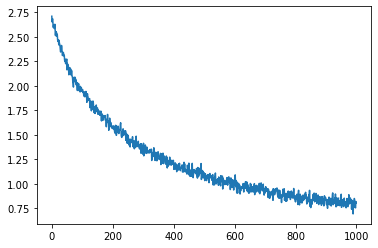

---------------------
Final score: 78.31 %
---------------------
CPU times: user 31min 55s, sys: 20.2 s, total: 32min 16s
Wall time: 32min 31s


In [29]:
%%time
alpha = 5 * 10**(-4)

K = 1000
list_L = torch.zeros(K)
optimizer = optim.Adam([W_lr1, b_lr1, W_lr2, b_lr2], lr=alpha)

for k in range(K):
    #loss = 0
    batch_index = list(np.random.randint(0,len(test_set),32))
    batch = [test_set[i] for i in batch_index]
    
    optimizer.zero_grad()
    loss = Loss(softmax, batch, W_lr1, b_lr1, W_lr2, b_lr2)
    score = accuracy(softmax, batch, W_lr1, b_lr1, W_lr2, b_lr2)
    loss.backward()
    optimizer.step()

    list_L[k] = loss.item()

    if k % 50 == 0:
        print('{:s}'.format('\u0332'.join('Iteration:')), k)
        print("Loss:", list_L[k])
        print("Score: {} %".format(np.round(score*100,2)))
        print('---------------------')
        

plt.plot(list_L)
plt.show()

print('---------------------')
print("Final score: {} %".format(np.round(score*100,2)))
print('---------------------')